In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os, sys, gc

import svgutils.transform as sg 

import scipy
from scipy.interpolate import RegularGridInterpolator

import h5py 

import class_energy as energy

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

## Functions for plotting, IO and time propagation

First: a function that allows quick plotting of wavefunctions

In [2]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [3]:
def get_tx_ty(sum, diff):
    '''  
    Return tx and ty tunneling rates
    '''
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

## Define Calculation Parameters

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,   
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-9}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 
test = 1

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

Scan specifications

In [5]:
sum_tx_ty = 200

V_0_arr_fo = np.arange(0,355,5)
V_0_arr_fdv = np.arange(0,355,5)
V_0_arr_fdh = np.arange(0,355,5)
V_0_arr_sp = np.arange(0,355,5)

V_0_arr = np.arange(0,355,5)

diff_tx_ty_fo = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
diff_tx_ty_fdh = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
diff_tx_ty_fdv = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
diff_tx_ty_sp = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])

diff_tx_ty = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])

In [6]:
def get_psi_properties(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr

In [7]:
def get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path):
    V_0_order = []
    E_order = []
    B_order = []
    V_order = []
    Tx_order = []
    Ty_order = []
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        check_sym  = 'tx_'+str(tx)+'_ty_'+str(ty)
        
        V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties(file_path, check_size, check_sym)

        V_0_order.append(V_0_list)
        E_order.append(E_arr)
        B_order.append(B_arr)
        V_order.append(V_arr)
        Tx_order.append(Tx_arr)
        Ty_order.append(Ty_arr)
    
    V_0_order = np.array([x for x in V_0_order])
    E_order = np.array([x for x in E_order])
    B_order = np.array([x for x in B_order])
    V_order = np.array([x for x in V_order])
    Tx_order = np.array([x for x in Tx_order])
    Ty_order = np.array([x for x in Ty_order])

    return V_0_order, E_order, Tx_order, Ty_order

### Read in calculation results

In [8]:
''' 
FO Results
'''
check_size = '_B_1.0_Mx_8_My_8'
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_fo, E_fo_orig, Tx_fo_orig, Ty_fo_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fo, file_path)

''' 
FDh Results
'''
check_size = '_B_1.0_Mx_32_My_4'
file_path = 'results/phase_diagram/fdh/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdh, E_fdh_orig, Tx_fdh_orig, Ty_fdh_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fdh, file_path)

''' 
FDv Results
'''
check_size = '_B_1.0_Mx_4_My_32'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdv, E_fdv_orig, Tx_fdv_orig, Ty_fdv_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fdv, file_path)

''' 
SP Results
'''
check_size = 'Mx_8_My_8'
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sp, E_sp_orig, Tx_sp_orig, Ty_sp_orig = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sp, file_path)

Reading results from FO calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from SP calculations - please wait!


Filter out the energies which don't correspond to the respective state and set the respective energies to zero. This helps in the further analysis.

In [9]:
def clean_phase(E_arr, Tx, Ty, phase):
    E_arr_n = np.zeros(E_arr.shape, dtype=complex)
    Tx_n = np.zeros(E_arr.shape, dtype=complex)
    Ty_n = np.zeros(E_arr.shape, dtype=complex)

    for i in range(E_arr.shape[0]):
        for j in range(E_arr.shape[1]):
            if phase == 'fo':
                if Tx[i,j] > 0.1 and Ty[i,j] > 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'fdv':
                if Ty[i,j] > 0.5 and Tx[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'fdh':
                if Tx[i,j] > 0.5 and Ty[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'sp':
                if Ty[i,j] < 0.1 and Tx[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j] 
    return E_arr_n, Tx_n, Ty_n
    
E_fo, Tx_fo, Ty_fo = clean_phase(E_fo_orig, np.abs(Tx_fo_orig), np.abs(Ty_fo_orig), 'fo')
E_fdv, Tx_fdv, Ty_fdv = clean_phase(E_fdv_orig, np.abs(Tx_fdv_orig), np.abs(Ty_fdv_orig), 'fdv')
E_fdh, Tx_fdh, Ty_fdh = clean_phase(E_fdh_orig, np.abs(Tx_fdh_orig), np.abs(Ty_fdh_orig), 'fdh')
E_sp, Tx_sp, Ty_sp = clean_phase(E_sp_orig, np.abs(Tx_sp_orig), np.abs(Ty_sp_orig), 'sp')

'''
This are manual correction!!
'''
E_fdv[0][0] = -400.0
E_fdv[0][1] = 0.5*(-400+E_fdv[0][2])

E_fdh[17][1] = 0.5*(-400+E_fdv[0][2])
E_fdh[17][0] = -400

Now we can determine the minimum energy at the respective coupling and symmetry points.

In [10]:
def get_gs_props(E_arr_fo, E_arr_fdv, E_arr_fdh, E_arr_sp, 
                 Tx_fo, Ty_fo, Tx_fdv, Ty_fdv, Tx_fdh, Ty_fdh, Tx_sp, Ty_sp):
    state_no = 0

    E_gs = np.zeros(E_arr_fo.shape, dtype=complex)
    Tx_order = np.zeros(E_arr_fo.shape, dtype=complex)
    Ty_order = np.zeros(E_arr_fo.shape, dtype=complex)

    for i in range(len(diff_tx_ty)):
        for j in range(len(V_0_arr)):
            E_fo  = E_arr_fo[i,j].real
            E_fdv = E_arr_fdv[i,j].real
            E_fdh = E_arr_fdh[i,j].real
            E_sp  = E_arr_sp[i,j].real

            Tx_fo_s  = Tx_fo[i,j]
            Tx_fdv_s = Tx_fdv[i,j]
            Tx_fdh_s = Tx_fdh[i,j]
            Tx_sp_s  = Tx_sp[i,j]

            Ty_fo_s  = Ty_fo[i,j]
            Ty_fdv_s = Ty_fdv[i,j]
            Ty_fdh_s = Ty_fdh[i,j]
            Ty_sp_s  = Ty_sp[i,j]

            E_arr  = np.array([E_fo,E_fdv,E_fdh,E_sp])
            Tx_arr = np.array([Tx_fo_s,Tx_fdv_s,Tx_fdh_s,Tx_sp_s])
            Ty_arr = np.array([Ty_fo_s,Ty_fdv_s,Ty_fdh_s,Ty_sp_s])

            E_index = np.argsort(E_arr)

            E_arr  = E_arr[E_index]
            Tx_arr = Tx_arr[E_index]
            Ty_arr = Ty_arr[E_index]
        
            E_gs[i,j] = E_arr[state_no]
            Tx_order[i,j] = Tx_arr[state_no]
            Ty_order[i,j] = Ty_arr[state_no]
    return E_gs, Tx_order, Ty_order

E_gs, Tx_order, Ty_order = get_gs_props(E_fo, E_fdv, E_fdh, E_sp, Tx_fo, Ty_fo, Tx_fdv, Ty_fdv, Tx_fdh, Ty_fdh, Tx_sp, Ty_sp)

Now we can interpolate the data.

In [11]:
def interpolate_data(x, y, data):
    f = scipy.interpolate.RegularGridInterpolator((x.real, y[0].real), data.real)
    
    Xnew = np.linspace(x[0].real, x[-1].real, 300)
    Ynew = np.linspace(y[0][0].real, y[0][-1].real, 300)
    Xnew, Ynew = np.meshgrid(Xnew, Ynew, indexing='ij')

    data_new = f((Xnew,Ynew), method='linear')
    return Xnew, Ynew, data_new

X_intp_fo, Y_intp_fo, E_fo_interp = interpolate_data(diff_tx_ty_fo, V_0_arr_fo.real, E_fo.real)
X_intp_fdv, Y_intp_fdv, E_fdv_interp = interpolate_data(diff_tx_ty_fdv, V_0_arr_fdv.real, E_fdv.real)
X_intp_fdh, Y_intp_fdh, E_fdh_interp = interpolate_data(diff_tx_ty_fdh, V_0_arr_fdh.real, E_fdh.real)
X_intp_sp, Y_intp_sp, E_sp_interp = interpolate_data(diff_tx_ty_sp, V_0_arr_sp.real, E_sp.real)

X_intp, Y_intp, Tx_fo_interp = interpolate_data(diff_tx_ty, V_0_arr_fo.real, Tx_fo.real)
X_intp, Y_intp, Tx_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr_fdv.real, Tx_fdv.real)
X_intp, Y_intp, Tx_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr_fdh.real, Tx_fdh.real)
X_intp, Y_intp, Tx_sp_interp = interpolate_data(diff_tx_ty, V_0_arr_sp.real, Tx_sp.real)

X_intp, Y_intp, Ty_fo_interp = interpolate_data(diff_tx_ty, V_0_arr_fo.real, Ty_fo.real)
X_intp, Y_intp, Ty_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr_fdv.real, Ty_fdv.real)
X_intp, Y_intp, Ty_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr_fdh.real, Ty_fdh.real)
X_intp, Y_intp, Ty_sp_interp = interpolate_data(diff_tx_ty, V_0_arr_sp.real, Ty_sp.real)

E_gs_int = np.zeros(E_fo_interp.shape)
Tx_gs_int = np.zeros(E_fo_interp.shape)
Ty_gs_int = np.zeros(E_fo_interp.shape)
for i in range(len(X_intp_fo)):
    for j in range(len(X_intp_fo.T)):
        E_arr = np.array([E_fo_interp[i,j],E_fdv_interp[i,j],E_fdh_interp[i,j],E_sp_interp[i,j]])
        Tx_arr = np.array([Tx_fo_interp[i,j],Tx_fdv_interp[i,j],Tx_fdh_interp[i,j],Tx_sp_interp[i,j]])
        Ty_arr = np.array([Ty_fo_interp[i,j],Ty_fdv_interp[i,j],Ty_fdh_interp[i,j],Ty_sp_interp[i,j]])
        
        E_index = np.argsort(E_arr)
        
        E_arr = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs_int[i,j] = E_arr[0].real
        Tx_gs_int[i,j] = Tx_arr[0].real #np.max(Tx_arr).real
        Ty_gs_int[i,j] = Ty_arr[0].real #np.max(Ty_arr).real

### Plot the energies and the phase diagram

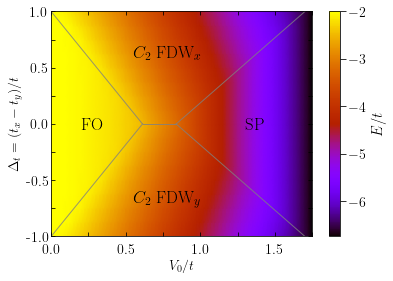

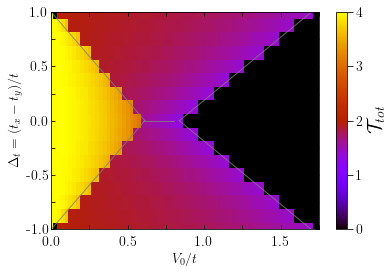

In [12]:
t = 200
X, Y = np.meshgrid(V_0_arr.real, diff_tx_ty.real)

#X_intp1, Y_intp1, E_gs_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_gs.real)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 14

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

#pc = plt.pcolormesh(X,Y,E_gs.real, linewidth=0.)
pc = ax.pcolormesh(X/t, Y/t, E_gs.real/t, antialiased=False, cmap='gnuplot', shading='gouraud')

cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$E/t$', size=15)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

plt.plot(np.array([0,0.612]), np.array([1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0,0.612]), np.array([-1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,-1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.612,0.8375]), np.array([0,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)

#ax.annotate(r'a)', xy=(0.2, -0.1), xytext=(-0.5, 0.9), fontsize=25, color='black')

ax.annotate(r'FO', xy=(0.2, -0.1), xytext=(0.2, -0.051), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_x$', xy=(0.2, 0), xytext=(0.55, 0.6), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_y$', xy=(0.2, 0), xytext=(0.55, -0.7), fontsize=17, color='black')
ax.annotate(r'SP', xy=(0.2, -0.1), xytext=(1.3, -0.051), fontsize=17, color='black')

plt.xlim(0,V_0_arr[-1].real/t)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\Delta_t = (t_x-t_y)/t$', fontsize=font_size)

plt.xticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75],[r'0.0',r'',r'0.5',r'',r'1.0',r'',r'1.5',r''],fontsize=font_size)
plt.yticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1],[r'-1.0',r'',r'-0.5',r'',r'0.0',r'',r'0.5',r'',r'1.0'],fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/phase_diagram/energies_B_1.0.pdf', bbox_inches='tight', dpi=50)
plt.show()


#X_intp, Y_intp, order_p_interp = interpolate_data(diff_tx_ty, V_0_arr[0], order_p.real)

fig = plt.figure()

pc = plt.pcolormesh(X/t, Y/t, np.abs(Tx_order+Ty_order), shading='auto', cmap='gnuplot')

cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$\mathcal{T}_{tot}$', size=20)

plt.plot(np.array([0,0.612]), np.array([1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0,0.612]), np.array([-1,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.8375,1.7]), np.array([0,-1]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)
plt.plot(np.array([0.6,0.8]), np.array([0,0]), linestyle='solid', color='grey', linewidth=1, alpha=0.8)

plt.xlim(0,V_0_arr[-1].real/t)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\Delta_t = (t_x-t_y)/t$', fontsize=font_size)

plt.xticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75],[r'0.0',r'',r'0.5',r'',r'1.0',r'',r'1.5',r''],fontsize=font_size)
plt.yticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1],[r'-1.0',r'',r'-0.5',r'',r'0.0',r'',r'0.5',r'',r'1.0'],fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.show()

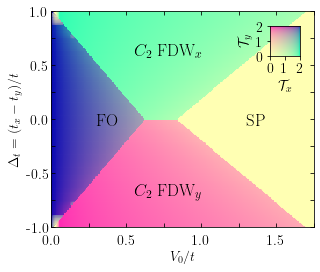

In [13]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 14

fig, ax = plt.subplots(figsize=[53 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
#ax.set_aspect("equal")

y = np.linspace(diff_tx_ty[0].real, diff_tx_ty[-1].real, 300)/200 
x = np.linspace(V_0_arr[0].real, V_0_arr[-1].real, 300)/t 

'''
A very simple colormap:
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the blue channel
'''
green_frac = 0.7
cmap = lambda p1,p2 : ((1-np.abs(p1/2))**(1/3), (1-np.abs(p2/2))**(1/3), green_frac)


p1 = Tx_fdv_interp 
p2 = Ty_fdv_interp 
for j in range(len(y)):
    x_int1 = 0.612*(y[j]+1)
    x_int2 = -(1.7-0.8375)*y[j] + 0.8375
    for i in range(len(x)):
        if x[i] > x_int1 and x[i] < x_int2 and y[j] < 0:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)

p1 = Tx_fdh_interp
p2 = Ty_fdh_interp 
for j in range(len(y)):
    x_int1 = -0.612*(y[j]-1)
    x_int2 = (1.7-0.8375)*y[j] + 0.8375
    for i in range(len(x)):
        if x[i] > x_int1 and x[i] < x_int2 and y[j] > 0:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)

p1 = Tx_fo_interp 
p2 = Ty_fo_interp 
for j in range(len(y)):
    x_int1 = 0.612*(y[j]+1)
    x_int2 = -0.612*(y[j]-1)
    for i in range(len(x)):
        if x[i] < x_int1 and x[i] < x_int2:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)
            
p1 = Tx_sp_interp 
p2 = Ty_sp_interp 
for j in range(len(y)):
    x_int1 = -(1.7-0.8375)*y[j] + 0.8375
    x_int2 = (1.7-0.8375)*y[j] + 0.8375
    for i in range(len(x)):
        if x[i] > x_int1 and x[i] > x_int2:
            circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.006, 0.006, color=cmap(p1[j,i],p2[j,i]))
            ax.add_artist(circle)
            
#plt.plot(np.array([0,0.612]), np.array([1,0]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0,0.612]), np.array([-1,0]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0.8375,1.7]), np.array([0,1]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0.8375,1.7]), np.array([0,-1]), linestyle='dashed', color='grey', linewidth=4, alpha=1)
#plt.plot(np.array([0.612,0.8375]), np.array([0,0]), linestyle='dashed', color='grey', linewidth=4, alpha=1)

#ax.annotate(r'b)', xy=(0.2, -0.1), xytext=(-0.5, 1.5), fontsize=25, color='black')

ax.annotate(r'FO', xy=(0.2, -0.1), xytext=(0.3, -0.051), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_x$', xy=(0.2, 0), xytext=(0.55, 0.6), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_y$', xy=(0.2, 0), xytext=(0.55, -0.7), fontsize=17, color='black')
ax.annotate(r'SP', xy=(0.2, -0.1), xytext=(1.3, -0.051), fontsize=17, color='black')

plt.xlim(0,1.75)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\Delta_t = (t_x-t_y)/t$', fontsize=font_size)

plt.xticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75],[r'0.0',r'',r'0.5',r'',r'1.0',r'',r'1.5',r''],fontsize=font_size)
plt.yticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1],[r'-1.0',r'',r'-0.5',r'',r'0.0',r'',r'0.5',r'',r'1.0'],fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.subplots_adjust(left=0.1, right=0.65, top=0.85)
cax = fig.add_axes([0.54,0.7,0.1,0.1]) #fig.add_axes([0.72,0.55,0.3,0.3])
cp1 = np.linspace(0, 1, 100)
cp2 = np.linspace(0, 1, 100)
Cp1, Cp2 = np.meshgrid(cp1,cp2)
C0 = green_frac*np.ones_like(Cp2)
# make RGB image, p1 to red channel, p2 to blue channel
Legend = np.dstack(((1-Cp1)**(1/3),(1-Cp2)**(1/3),C0))

# parameters range between 0 and 1
cax.imshow(Legend, origin="lower", extent=[0,2,0,2])
cax.set_xticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_yticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_xlabel(r'$\mathcal{T}_x$', fontsize=font_size)
cax.set_ylabel(r'$\mathcal{T}_y$', fontsize=font_size)
#cax.set_title("2D cmap legend", fontsize=10)

plt.savefig('results/phase_diagram/order_parameters_B_1.0.pdf', bbox_inches='tight', dpi=50)
plt.show()

In [15]:
import svgutils.transform as sg 

fig = sg.SVGFigure("16cm", "16cm")

fig1 = sg.fromfile('results/phase_diagram/energies_B_1.0.svg')
fig2 = sg.fromfile('results/phase_diagram/order_parameters_B_1.0.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot2.moveto(5,300)

txt1 = sg.TextElement(0,20, r"a)", size=20)
txt2 = sg.TextElement(0,330, r"b)", size=20) 

fig.append([plot1,plot2])
#fig.append([txt1,txt2])

fig.save('results/phase_diagram/phase_diagram_B_1.0.svg')

#### Comparison of FO for different symmetry realizations

The energies in the FO show a quadratic dependence on the coupling $V_0$. Here, we give an intuition for the dependence of the prefactor on the asymmetry $t_x-t_y$.

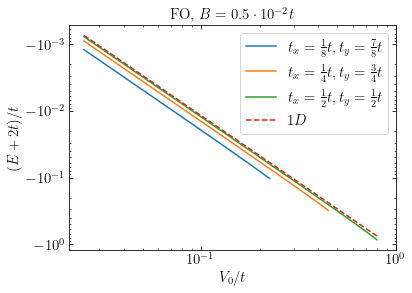

In [14]:
def get_non_zero(V, E):
    index_nonzero = np.where(E < 0)

    E_nonzero = E[index_nonzero]
    V_nonzero = V[index_nonzero]
    return V_nonzero, E_nonzero

def E_roughly_quad(V, t, B):
    return -2*t-2*0.59*0.005*V**2#/np.sqrt(B*(B+4*t))


V1_fo, E1_fo = get_non_zero(V_0_arr_fo[0][1:], E_fo[2][1:])
V2_fo, E2_fo = get_non_zero(V_0_arr_fo[0][1:], E_fo[4][1:])
V3_fo, E3_fo = get_non_zero(V_0_arr_fo[0][1:], E_fo[5][1:])
V4_fo, E4_fo = get_non_zero(V_0_arr_fo[0][1:], E_fo[8][1:])


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])

plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V1_fo.real/t, -(E1_fo+2*t).real/t, label=r'$t_x=\frac{1}{8}t,t_y=\frac{7}{8}t$')
plt.plot(V2_fo.real/t, -(E2_fo+2*t).real/t, label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
plt.plot(V4_fo.real/t, -(E4_fo+2*t).real/t, label=r'$t_x=\frac{1}{2}t,t_y=\frac{1}{2}t$')

plt.plot(V4_fo.real/t, -(E_roughly_quad(V4_fo.real,200,1)+2*t).real/t, linestyle='dashed', label=r'$1D$')


plt.xscale('log')
plt.yscale('log')

ax.invert_yaxis() 

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks([1e-1,1e0], [r'$10^{-1}$',r'$10^{0}$'], fontsize=font_size)
plt.yticks([1e0,1e-1,1e-2,1e-3], [r'$-10^{0}$',r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)
plt.tick_params(which='minor', axis='x', direction='in', top=True, labelsize=font_size)
plt.tick_params(which='minor', axis='y', direction='in', right=True, labelsize=font_size)

plt.legend(fontsize=font_size)
plt.savefig('results/phase_diagram/FO_comp.svg')

#### Comparison of FDW$_y$ for different symmetry realizations

Here we compare the Ferro-Domain wall energies for different symmetry realization. Essentially, they show roughly linear dependence with the same slope but shifted offset. 

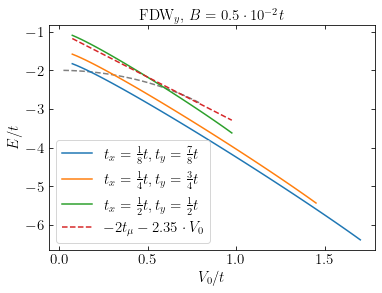

In [15]:
def get_non_zero(V, E):
    index_nonzero = np.where(E < 0)
    E_nonzero = E[index_nonzero]
    V_nonzero = V[index_nonzero]
    return V_nonzero, E_nonzero

def E_roughly_quad(V, t, B):
    return -200-t-2.35*V #2*np.sqrt(2)


V0_fo, E0_fo = get_non_zero(V_0_arr_fo[0][1:], E_fo[8][1:])

V1_fdv, E1_fdv = get_non_zero(V_0_arr_fdv[0][0:], E_fdv[2][0:])
V2_fdv, E2_fdv = get_non_zero(V_0_arr_fdv[0][0:], E_fdv[4][0:])
V3_fdv, E3_fdv = get_non_zero(V_0_arr_fdv[0][1:], E_fdv[5][1:])
V4_fdv, E4_fdv = get_non_zero(V_0_arr_fdv[0][0:], E_fdv[8][0:])


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])

plt.title(r'FDW$_y$, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V0_fo.real/t, (E0_fo+0*t).real/t, linestyle='dashed', color='grey')

plt.plot(V1_fdv.real/t, (E1_fdv+0*t).real/t, label=r'$t_x=\frac{1}{8}t,t_y=\frac{7}{8}t$')
plt.plot(V2_fdv.real/t, (E2_fdv+0*t).real/t, label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
plt.plot(V4_fdv.real/t, (E4_fdv+0*t).real/t, label=r'$t_x=\frac{1}{2}t,t_y=\frac{1}{2}t$')

plt.plot(V4_fdv.real/t, (E_roughly_quad(V4_fdv.real,0,1)+0*t).real/200, linestyle='dashed', label=r'$-2t_{\mu}-2.35\cdot V_0$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

#plt.xticks([1e-1,1e0], [r'$10^{-1}$',r'$10^{0}$'], fontsize=font_size)
#plt.yticks([1e0,1e-1,1e-2,1e-3], [r'$-10^{0}$',r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)
plt.tick_params(which='minor', axis='x', direction='in', top=True, labelsize=font_size)
plt.tick_params(which='minor', axis='y', direction='in', right=True, labelsize=font_size)

plt.legend(fontsize=font_size)
#plt.savefig('results/phase_diagram/FO_comp.svg')

#### Convergence with lattice size in FO

Problem: the offset differences for the different asymmetry realizations in the FO might be due to finite size effects, i.e. in principle we would have to adapt the grid size when changing the ratio of $t_x$ and $t_y$. Here we compare the energies over the relevant coupling range for an asymmetric realization. We see that there is a finite size error, but it is small enough!

Reading results from FO 32x32 calculations - please wait!
Reading results from FO 64x64 calculations - please wait!

e-diff 8-32 = [0.00723851+4.27453245e-20j 0.02718064-6.89589135e-20j
 0.06134697-4.41209882e-19j 0.11288528-2.78433011e-19j
 0.18823972+8.01090669e-19j 0.29727177-8.71090888e-19j
 0.4546422 +8.87533937e-19j 0.68665368+1.76533063e-18j
 1.04976348-2.96653804e-18j]

e-diff 8-64 = [0.00723789+2.64281381e-20j 0.02717125+2.82037091e-20j
 0.06133304+1.66242667e-19j 0.11298363-6.68593454e-20j
 0.18859188+7.28312649e-20j 0.29809847-7.27514464e-19j
 0.45637228+3.58166816e-19j 0.68998839-4.37706768e-18j
 1.05541062-1.95759925e-18j]


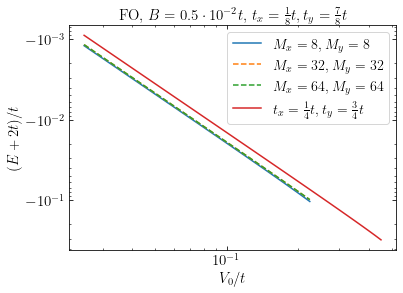

In [16]:
''' 
FO Results M=32*32
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/fo/'

diff_tx_ty_fo_sys_check = np.array([150])

print('Reading results from FO 32x32 calculations - please wait!')
V_0_arr_fo_check, E_fo_orig_check, Tx_fo_orig_check, Ty_fo_orig_check = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fo_sys_check, file_path)


''' 
FO Results M=64*64
'''
check_size = '_B_1.0_Mx_64_My_64'
file_path = 'results/phase_diagram/fo/'

diff_tx_ty_fo_sys_check = np.array([150])

print('Reading results from FO 64x64 calculations - please wait!')
V_0_arr_fo_check64, E_fo_orig_check64, Tx_fo_orig_check64, Ty_fo_orig_check64 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fo_sys_check, file_path)


'''
Compute differences
'''
diff_energies_fo_as = E_fo_orig_check[0]-E1_fo
diff_energies_fo_as64 = E_fo_orig_check64[0]-E1_fo

print('\ne-diff 8-32 =', diff_energies_fo_as)
print('\ne-diff 8-64 =', diff_energies_fo_as64)


'''
Plot
'''
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])

plt.title(r'FO, $B=0.5\cdot 10^{-2}t$, $t_x=\frac{1}{8}t,t_y=\frac{7}{8}t$', fontsize=font_size)

plt.plot(V1_fo.real/t, -(E1_fo+2*t).real/t, label=r'$M_x=8,M_y=8$')
plt.plot(V_0_arr_fo_check[0].real/t, -(E_fo_orig_check[0]+2*t).real/t, linestyle='dashed', label=r'$M_x=32,M_y=32$')
plt.plot(V_0_arr_fo_check64[0].real/t, -(E_fo_orig_check64[0]+2*t).real/t, linestyle='dashed', label=r'$M_x=64,M_y=64$')

plt.plot(V2_fo.real/t, -(E2_fo+2*t).real/t, label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')


plt.xscale('log')
plt.yscale('log')

ax.invert_yaxis() 

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks([1e-1,1e-2,1e-3], [r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)
plt.tick_params(which='minor', axis='x', direction='in', top=True, labelsize=font_size)
plt.tick_params(which='minor', axis='y', direction='in', right=True, labelsize=font_size)

plt.legend(fontsize=0.95*font_size, loc=1)

## Confirmation of FD domain existence for $\Delta_t = 0$

The computation of the vGH energies shows finite-size dependence. Hence, we compute the energies for big lattices where we are sure that the energies are converged (within ...). This computational experiment \textbf{confirms the existence of the ferro-domains in the symmetric case} and is hence one of the most crucial plots in terms of confirmation of our symmetry-breaking story!

TODO: summary of how long the cluster computations took for this lattice system!

In [17]:
diff_tx_ty_sym = np.array([0])

''' 
FO Results
'''
check_size = '_B_1.0_Mx_32_My_32_qx_0_qy_0'
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_sym_fo_deg_test, E_fo_sym, Tx_fo_sym, Ty_fo_sym = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


''' 
FDv Results
'''
check_size = '_B_1.0_Mx_4_My_256_qx_0_qy_0'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_arr_sym_fdv_deg_test, E_fdv_sym, Tx_fdv_sym, Ty_fdv_sym = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


''' 
SP Results
'''
check_size = '_B_1.0_Mx_8_My_8_qx_0_qy_0'
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sym_sp_deg_test, E_sp_sym, Tx_sp_sym, Ty_sp_sym = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)

Reading results from FO calculations - please wait!
Reading results from FDv calculations - please wait!
Reading results from SP calculations - please wait!


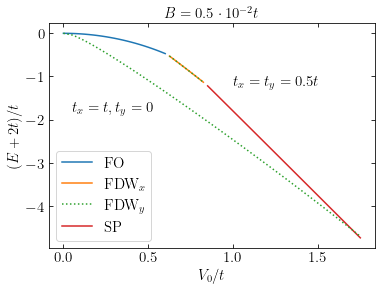

In [18]:
E_sym_fo_n, Tx_sym_fo_n, Ty_sym_fo_n = clean_phase(E_fo_sym, np.abs(Tx_fo_sym), np.abs(Ty_fo_sym), 'fo')
E_sym_fdv_n, Tx_sym_fdv_n, Ty_sym_fdv_n = clean_phase(E_fdv_sym, np.abs(Tx_fdv_sym), np.abs(Ty_fdv_sym), 'fdv')
E_sym_sp_n, Tx_sym_sp_n, Ty_sym_sp_n = clean_phase(E_sp_sym, np.abs(Tx_sp_sym), np.abs(Ty_sp_sym), 'sp')

def find_minimum_e(E1, E2, E3, E4, V_0_arr, V_0_arr_index, arr_num):
    V_list = []
    E_list = []
    index_list = []
    for i in range(len(V_0_arr_index[0])):
        E_arr = np.array([E1[0,i],E2[0,i],E3[0,i],E4[0,i]])

        if E_arr[int(arr_num)] == np.min(E_arr):
            V_list.append(V_0_arr[0,i])
            E_list.append(E_arr[arr_num])
            index_list.append(i)

    return np.array(V_list), np.array(E_list), index_list

V_min_fo, E_min_fo, ind_list_fo = find_minimum_e(E_sym_fo_n, E_sym_fdv_n, E_sym_fdv_n, E_sym_sp_n, V_0_arr_sym_fo_deg_test, V_0_arr_sym_fdv_deg_test, 0)
V_min_fdv, E_min_fdv, ind_list_fdv = find_minimum_e(E_sym_fo_n, E_sym_fdv_n, E_sym_fdv_n, E_sym_sp_n, V_0_arr_sym_fdv_deg_test, V_0_arr_sym_fdv_deg_test, 1)
V_min_sp, E_min_sp, ind_list_sp = find_minimum_e(E_sym_fo_n, E_sym_fdv_n, E_sym_fdv_n, E_sym_sp_n, V_0_arr_sym_sp_deg_test, V_0_arr_sym_fdv_deg_test, 3)


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])

plt.title(r'$B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V_min_fo.real/t, E_min_fo.real/t+2, label=r'FO')
plt.plot(V_min_fdv.real/t, E_min_fdv.real/t+2, label=r'FDW$_x$')
plt.plot(V_min_fdv.real/t, E_min_fdv.real/t+2, linestyle='dotted', label=r'FDW$_y$')
plt.plot(V_min_sp.real[0:37]/t, E_min_sp.real[0:37]/t+2, label=r'SP')

plt.plot(V_0_arr_sym_fo_deg_test[0].real/t, E_fdv.real[0]/t+2, linestyle='dotted', color='tab:green')

#plt.vlines(0.612, ymin=np.min(E_min_sp.real[0:37]/t+2), ymax=1, linestyle='dashed', color='grey', alpha=0.8)
#plt.vlines(0.8375, ymin=np.min(E_min_sp.real[0:37]/t+2), ymax=1, linestyle='dashed', color='grey', alpha=0.8)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

ax.annotate(r'$t_x=t,t_y=0$', xy=(0.05, -1.5), xytext=(0.05, -1.8), fontsize=15, color='black')
ax.annotate(r'$t_x=t_y=0.5t$', xy=(0.8, -1.2), xytext=(1, -1.2), fontsize=15, color='black')

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True, labelsize=font_size)

plt.legend(fontsize=font_size, loc=3)
plt.savefig('results/phase_diagram/vGH_energies_symmetric_asymmetric_comparison.svg', bbox_inches='tight', dpi=50)

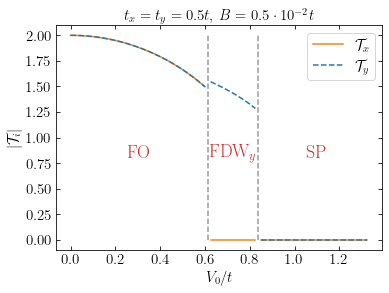

In [19]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])

plt.title(r'$t_x=t_y=0.5t$, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

plt.plot(V_min_fo.real/t, np.abs(Tx_fo_sym[0][ind_list_fo]), color='tab:orange', label=r'$\mathcal{T}_x$')
plt.plot(V_min_fo.real/t, np.abs(Ty_fo_sym[0][ind_list_fo]), color='tab:blue', linestyle='dashed', label=r'$\mathcal{T}_y$')

plt.plot(V_min_fdv.real/t, np.abs(Tx_fdv_sym[0][ind_list_fdv]), color='tab:orange')
plt.plot(V_min_fdv.real/t, np.abs(Ty_fdv_sym[0][ind_list_fdv]), color='tab:blue', linestyle='dashed')

plt.plot(V_min_sp[0:20].real/t, np.abs(Tx_sp_sym[0][ind_list_sp])[0:20], color='tab:orange')
plt.plot(V_min_sp[0:20].real/t, np.abs(Ty_sp_sym[0][ind_list_sp])[0:20], color='tab:blue', linestyle='dashed')

plt.vlines(0.612, ymin=0, ymax=2, linestyle='dashed', color='grey', alpha=0.8)
plt.vlines(0.8375, ymin=0, ymax=2, linestyle='dashed', color='grey', alpha=0.8)

ax.annotate(r'FO', xy=(0.25, 0.6), xytext=(0.25, 0.8), fontsize=18, color='tab:red')
ax.annotate(r'FDW$_y$', xy=(0.25, 0.6), xytext=(0.62, 0.8), fontsize=18, color='tab:red')
ax.annotate(r'SP', xy=(0.25, 0.6), xytext=(1.05, 0.8), fontsize=18, color='tab:red')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$|\mathcal{T}_i|$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size)

## Comparison for different values of $B$

Here we show that for larger $B$, the prefactor of the quadratic potential term gets smaller.

In [20]:
diff_tx_ty_sym = np.array([0])

''' 
FO Results
'''
check_size = '_B_200.0_Mx_80_My_80_qx_0_qy_0'
file_path = 'results/eff_mass/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_sym_B_200, E_fo_sym_B_200, Tx_fo_sym_B_200, Ty_fo_sym_B_200 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


Reading results from FO calculations - please wait!


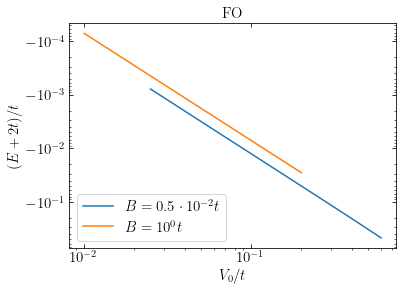

In [21]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'FO', fontsize=font_size)

plt.plot(V_min_fo[1:].real/t, -E_min_fo[1:].real/t-2, label=r'$B=0.5\cdot 10^{-2}t$')
plt.plot(V_0_arr_sym_B_200[0].real/t, -E_fo_sym_B_200[0].real/t-2, label=r'$B = 10^{0}t$')

#plt.vlines(0.612, ymin=np.min(E_min_sp.real[0:37]/t+2), ymax=1, linestyle='dashed', color='grey', alpha=0.8)
#plt.vlines(0.8375, ymin=np.min(E_min_sp.real[0:37]/t+2), ymax=1, linestyle='dashed', color='grey', alpha=0.8)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

ax.annotate(r'$t_x=t,t_y=0$', xy=(0.05, -1.5), xytext=(0.05, -1.8), fontsize=15, color='black')
ax.annotate(r'$t_x=t_y=0.5t$', xy=(0.8, -1.2), xytext=(1, -1.2), fontsize=15, color='black')

ax.invert_yaxis()

plt.xticks(fontsize=font_size)
plt.yticks([1e-4,1e-3,1e-2,1e-1], [r'$-10^{-4}$',r'$-10^{-3}$',r'$-10^{-2}$',r'$-10^{-1}$'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=3)
#plt.savefig('results/phase_diagram/vGH_energies_symmetric_asymmetric_comparison.svg', bbox_inches='tight', dpi=50)

### Domain wall degeneracy for $\Delta_t = 0$ but higher $B$

In this experiment we compute the energies of all four phases in the symmetric regime for a larger rotational constant. The analysis shows that the degeneracy remains, but it is shifted to larger coupling values and the degeneracy window shrinks.

In [22]:
diff_tx_ty_sym = np.array([0])

''' 
FO Results
'''
check_size = '_B_10.0_Mx_32_My_32'
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_sym_fo_B_10, E_fo_sym_B_10, Tx_fo_sym_B_10, Ty_fo_sym_B_10 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)



''' 
FDv Results
'''
check_size = '_B_10.0_Mx_4_My_256'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_arr_sym_fdv_B_10, E_fdv_sym_B_10, Tx_fdv_sym_B_10, Ty_fdv_sym_B_10 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)



''' 
SP Results
'''
check_size = '_B_10.0_Mx_8_My_8'
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sym_sp_B_10, E_sp_sym_B_10, Tx_sp_sym_B_10, Ty_sp_sym_B_10 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)

Reading results from FO calculations - please wait!
Reading results from FDv calculations - please wait!
Reading results from SP calculations - please wait!


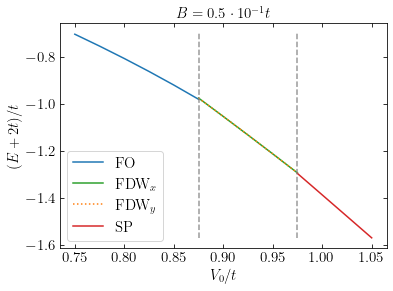

In [23]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$B=0.5\cdot 10^{-1}t$', fontsize=font_size)

plt.plot(V_0_arr_sym_fo_B_10[0][0:6].real/t, E_fo_sym_B_10[0][0:6].real/t+2, color='tab:blue', label=r'FO')
plt.plot(V_0_arr_sym_fdv_B_10[0][5:10].real/t, E_fdv_sym_B_10[0][5:10].real/t+2, color='tab:green', label=r'FDW$_x$')
plt.plot(V_0_arr_sym_fdv_B_10[0][5:10].real/t, E_fdv_sym_B_10[0][5:10].real/t+2, color='tab:orange', linestyle='dotted', label=r'FDW$_y$')
plt.plot(V_0_arr_sym_sp_B_10[0][9:].real/t, E_sp_sym_B_10[0][9:].real/t+2, color='tab:red', label=r'SP')

plt.vlines(0.876, ymin=np.min(E_sp_sym_B_10.real/t+2), ymax=-0.7, linestyle='dashed', color='grey', alpha=0.8)
plt.vlines(0.975, ymin=np.min(E_sp_sym_B_10.real/t+2), ymax=-0.7, linestyle='dashed', color='grey', alpha=0.8)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=3)
plt.savefig('results/phase_diagram/vGH_energies_larger_B_symmetric_lattice.svg', bbox_inches='tight', dpi=50)

## Symmetry Breaking in the coupling terms

We can consider a different kind of symmetry breaking, i.e. not a symmetry breaking in the tunneling rates but a symmetry breaking in the coupling terms. While there are several combinatorial options, we just focus on a single one here.

In [24]:
def get_psi_properties_sym_break(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy_sym_breaking(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr
    
def get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle, V_0_arr, file_path):
    V_0_order = []
    E_order = []
    B_order = []
    V_order = []
    Tx_order = []
    Ty_order = []
    for j in range(len(angle)):
        for i in range(len(V_0_arr)):
        #tx, ty = get_tx_ty(sum_tx_ty, 0)

            check_sym  = 'delta_angle'+str(angle[j])+'tx_100.0_ty_100.0_V0_'+str(V_0_arr[i])
            #print(check_sym)
            V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties_sym_break(file_path, check_size, check_sym)

            #print(len(V_0_list))
        
            V_0_order.append(V_0_list)
            E_order.append(E_arr)
            B_order.append(B_arr)
            V_order.append(V_arr)
            Tx_order.append(Tx_arr)
            Ty_order.append(Ty_arr)
    
    V_0_order = np.array([x for x in V_0_order]).reshape(len(angle), len(V_0_arr))
    E_order = np.array([x for x in E_order]).reshape(len(angle), len(V_0_arr))
    B_order = np.array([x for x in B_order]).reshape(len(angle), len(V_0_arr))
    V_order = np.array([x for x in V_order]).reshape(len(angle), len(V_0_arr))
    Tx_order = np.array([x for x in Tx_order]).reshape(len(angle), len(V_0_arr))
    Ty_order = np.array([x for x in Ty_order]).reshape(len(angle), len(V_0_arr))

    return V_0_order, E_order, Tx_order, Ty_order

In [25]:
angle_values = np.array([0.3,0.25,0.2,0.15,0.1,0.05,-0.0]) # np.array([-0.1,-0.0,0.1])
V_0_arr = np.array([120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145])
V_0_arr2 = np.arange(150,255,5)

''' 
FO Results
'''
check_size = '_B_2.0_Mx_16_My_16'
file_path = 'results/phase_diagram_sym_breaking_angle/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_fo_s1, E_fo_orig_s1, Tx_fo_orig_s1, Ty_fo_orig_s1 = get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle_values, V_0_arr, file_path)


''' 
FDv Results
'''
check_size = '_B_2.0_Mx_4_My_32'
file_path = 'results/phase_diagram_sym_breaking_angle/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_arr_fdv_s1, E_fdv_orig_s1, Tx_fdv_orig_s1, Ty_fdv_orig_s1 = get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle_values, V_0_arr, file_path)
V_0_arr_fdv_s2, E_fdv_orig_s2, Tx_fdv_orig_s2, Ty_fdv_orig_s2 = get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle_values, V_0_arr2, file_path)


''' 
FDh Results
'''
check_size = '_B_2.0_Mx_32_My_4'
file_path = 'results/phase_diagram_sym_breaking_angle/fdh/'

#print('Reading results from FDh calculations - please wait!')
#V_0_arr_fdh_s1, E_fdh_orig_s1, Tx_fdh_orig_s1, Ty_fdh_orig_s1 = get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle_values, V_0_arr, file_path)
#V_0_arr_fdv_s2, E_fdv_orig_s2, Tx_fdv_orig_s2, Ty_fdv_orig_s2 = get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle_values_fdv2, file_path)


''' 
SP Results
'''
check_size = '_B_2.0_Mx_8_My_8'
file_path = 'results/phase_diagram_sym_breaking_angle/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sp, E_sp_orig, Tx_sp_orig, Ty_sp_orig = get_e_arr_sym_break_phi(check_size, sum_tx_ty, angle_values, V_0_arr2, file_path)

Reading results from FO calculations - please wait!
Reading results from FDv calculations - please wait!
Reading results from SP calculations - please wait!


In [26]:
E_fo_angle, Tx_fo_angle, Ty_fo_angle = clean_phase(E_fo_orig_s1, np.abs(Tx_fo_orig_s1), np.abs(Ty_fo_orig_s1), 'fo')
E_fdv_angle, Tx_fdv_angle, Ty_fdv_angle = clean_phase(E_fdv_orig_s1, np.abs(Tx_fdv_orig_s1), np.abs(Ty_fdv_orig_s1), 'fdv')
E_fdv2_angle, Tx_fdv2_angle, Ty_fdv2_angle = clean_phase(E_fdv_orig_s2, np.abs(Tx_fdv_orig_s2), np.abs(Ty_fdv_orig_s2), 'fdv')
E_sp_angle, Tx_sp_angle, Ty_sp_angle = clean_phase(E_sp_orig, np.abs(Tx_sp_orig), np.abs(Ty_sp_orig), 'sp')

E_gs_angle = np.zeros(E_fo_angle.shape, dtype=complex)
Tx_gs_angle = np.zeros(Tx_fo_angle.shape, dtype=complex)
Ty_gs_angle = np.zeros(Ty_fo_angle.shape, dtype=complex)
for i in range(E_fo_angle.shape[0]):
    for j in range(E_fo_angle.shape[1]):
        E_arr_list = np.array([E_fo_angle[i,j], E_fdv_angle[i,j]])
        Tx_arr_list = np.array([Tx_fo_angle[i,j], Tx_fdv_angle[i,j]])
        Ty_arr_list = np.array([Ty_fo_angle[i,j], Ty_fdv_angle[i,j]])
        
        index_list = np.argsort(E_arr_list)

        E_arr_list = E_arr_list[index_list]
        Tx_arr_list = Tx_arr_list[index_list]
        Ty_arr_list = Ty_arr_list[index_list]
        
        E_gs_angle[i,j] = E_arr_list[0]
        Tx_gs_angle[i,j] = Tx_arr_list[0]
        Ty_gs_angle[i,j] = Ty_arr_list[0]

E_gs2_angle = np.zeros(E_fdv2_angle.shape, dtype=complex)
Tx_gs2_angle = np.zeros(Tx_fdv2_angle.shape, dtype=complex)
Ty_gs2_angle = np.zeros(Ty_fdv2_angle.shape, dtype=complex)
for i in range(E_fdv2_angle.shape[0]):
    for j in range(E_fdv2_angle.shape[1]):
        E_arr_list = np.array([E_fdv2_angle[i,j], E_sp_angle[i,j]])
        Tx_arr_list = np.array([Tx_fdv2_angle[i,j], Tx_sp_angle[i,j]])
        Ty_arr_list = np.array([Ty_fdv2_angle[i,j], Ty_sp_angle[i,j]])
        
        index_list = np.argsort(E_arr_list)

        E_arr_list = E_arr_list[index_list]
        Tx_arr_list = Tx_arr_list[index_list]
        Ty_arr_list = Ty_arr_list[index_list]
        
        E_gs2_angle[i,j] = E_arr_list[0]
        Tx_gs2_angle[i,j] = Tx_arr_list[0]
        Ty_gs2_angle[i,j] = Ty_arr_list[0]

(7, 47)


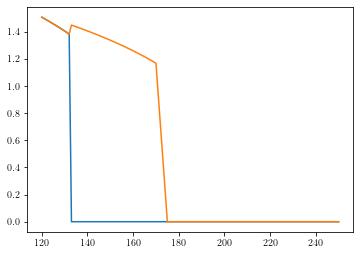

In [27]:
new_shape_tuple = (E_fo_angle.shape[0], E_fo_angle.shape[1]+E_fdv2_angle.shape[1])

print(new_shape_tuple)

V_0_arr_tot = np.append(V_0_arr, V_0_arr2)

E_gs_tot_angle = np.zeros(new_shape_tuple, dtype=complex)
Tx_gs_tot_angle = np.zeros(new_shape_tuple, dtype=complex)
Ty_gs_tot_angle = np.zeros(new_shape_tuple, dtype=complex)

for i in range(E_fo_angle.shape[0]):
    for j in range(E_fo_angle.shape[1]):
        E_gs_tot_angle[i,j] = E_gs_angle[i,j]
        Tx_gs_tot_angle[i,j] = Tx_gs_angle[i,j]
        Ty_gs_tot_angle[i,j] = Ty_gs_angle[i,j]

for i in range(E_fo_angle.shape[0]):
    for j in range(E_fo_angle.shape[1], E_fo_angle.shape[1]+E_fdv2_angle.shape[1]):
        E_gs_tot_angle[i,j] = E_gs2_angle[i,j-E_fo_angle.shape[1]]
        Tx_gs_tot_angle[i,j] = Tx_gs2_angle[i,j-E_fo_angle.shape[1]]
        Ty_gs_tot_angle[i,j] = Ty_gs2_angle[i,j-E_fo_angle.shape[1]]
        
plt.plot(V_0_arr_tot, Tx_gs_tot_angle.real[6])
plt.plot(V_0_arr_tot, Ty_gs_tot_angle.real[6])

In [28]:
def interpolate_data(x, y, data):    
    f = scipy.interpolate.RegularGridInterpolator((x.real, y.real), data.real)
    
    Xnew = np.linspace(x[0].real, x[-1].real, 300)
    Ynew = np.linspace(y[0].real, y[-1].real, 300)
    Xnew, Ynew = np.meshgrid(Xnew, Ynew, indexing='ij')

    data_new = f((Xnew,Ynew), method='linear')
    return Xnew, Ynew, data_new

X_a_intp_fo, Y_a_intp_fo, E_fo_angle_interp = interpolate_data(angle_values, V_0_arr.real, E_fo_angle.real)
X_a_intp_fdv, Y_a_intp_fdv, E_fdv_angle_interp = interpolate_data(angle_values, V_0_arr.real, E_fdv_angle.real)
X_a_intp_fdv2, Y_a_intp_fdv2, E_fdv2_angle_interp = interpolate_data(angle_values, V_0_arr2.real, E_fdv2_angle.real)
#X_intp_fdh, Y_a_intp_fdh, E_fdh_angle_interp = interpolate_data(diff_tx_ty_fdh, V_0_arr_fdh.real, E_fdh.real)
X_a_intp_sp, Y_a_intp_sp, E_sp_angle_interp = interpolate_data(angle_values, V_0_arr2.real, E_sp_angle.real)

X_a_intp_fo, Y_a_intp_fo, Tx_fo_angle_interp = interpolate_data(angle_values, V_0_arr.real, Tx_fo_angle.real)
X_a_intp_fdv, Y_a_intp_fdv, Tx_fdv_angle_interp = interpolate_data(angle_values, V_0_arr.real, Tx_fdv_angle.real)
X_a_intp_fdv2, Y_a_intp, Tx_fdv2_angle_interp = interpolate_data(angle_values, V_0_arr2.real, Tx_fdv2_angle.real)
#X_intp, Y_intp, Tx_fdh_interp = interpolate_data(angle_values, V_0_arr.real, Tx_fdh.real)
X_a_intp_sp, Y_a_intp_sp, Tx_sp_angle_interp = interpolate_data(angle_values, V_0_arr2.real, Tx_sp_angle.real)

X_a_intp_fo, Y_a_intp_fo, Ty_fo_angle_interp = interpolate_data(angle_values, V_0_arr.real, Ty_fo_angle.real)
X_a_intp_fdv, Y_a_intp_fdv, Ty_fdv_angle_interp = interpolate_data(angle_values, V_0_arr.real, Ty_fdv_angle.real)
X_a_intp_fdv2, Y_a_intp_fdv2, Ty_fdv2_angle_interp = interpolate_data(angle_values, V_0_arr2.real, Ty_fdv2_angle.real)
#X_intp, Y_intp, Ty_fdh_angle_interp = interpolate_data(angle_values, V_0_arr.real, Ty_fdh.real)
X_a_intp_sp, Y_a_intp_sp, Ty_sp_angle_interp = interpolate_data(angle_values, V_0_arr2.real, Ty_sp_angle.real)

new_shape_tuple = (E_fo_angle_interp.shape[0], E_fo_angle_interp.shape[1]+E_fdv2_angle_interp.shape[1])

E_gs_int_angle = np.zeros(new_shape_tuple)
Tx_gs_int_angle = np.zeros(new_shape_tuple)
Ty_gs_int_angle = np.zeros(new_shape_tuple)

for i in range(len(X_a_intp_fo.T)):
    for j in range(len(X_a_intp_fo)):
        E_arr = np.array([E_fo_angle_interp[i,j],E_fdv_angle_interp[i,j]]) #,E_fdh_interp[i,j],E_sp_interp[i,j]])
        Tx_arr = np.array([Tx_fo_angle_interp[i,j],Tx_fdv_angle_interp[i,j]]) #,Tx_fdh_interp[i,j],Tx_sp_angle_interp[i,j]])
        Ty_arr = np.array([Ty_fo_angle_interp[i,j],Ty_fdv_angle_interp[i,j]]) #,Ty_fdh_interp[i,j],Ty_sp_angle_interp[i,j]])
        
        E_index = np.argsort(E_arr)
        
        E_arr = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs_int_angle[i,j] = E_arr[0].real
        Tx_gs_int_angle[i,j] = Tx_arr[0].real #np.max(Tx_arr).real
        Ty_gs_int_angle[i,j] = Ty_arr[0].real #np.max(Ty_arr).real

for i in range(len(X_a_intp_fo.T)):
    for j in range(len(X_a_intp_fo), len(X_a_intp_fo)+len(X_a_intp_fdv2)):
        E_arr = np.array([E_sp_angle_interp[i,j-len(X_a_intp_fo)],E_fdv2_angle_interp[i,j-len(X_a_intp_fo)]]) #,E_fdh_interp[i,j],E_sp_interp[i,j]])
        Tx_arr = np.array([Tx_sp_angle_interp[i,j-len(X_a_intp_fo)],Tx_fdv2_angle_interp[i,j-len(X_a_intp_fo)]]) #,Tx_fdh_interp[i,j],Tx_sp_angle_interp[i,j]])
        Ty_arr = np.array([Ty_sp_angle_interp[i,j-len(X_a_intp_fo)],Ty_fdv2_angle_interp[i,j-len(X_a_intp_fo)]]) #,Ty_fdh_interp[i,j],Ty_sp_angle_interp[i,j]])
        
        E_index = np.argsort(E_arr)
        
        E_arr = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs_int_angle[i,j] = E_arr[0].real
        Tx_gs_int_angle[i,j] = Tx_arr[0].real #np.max(Tx_arr).real
        Ty_gs_int_angle[i,j] = Ty_arr[0].real #np.max(Ty_arr).real

In [29]:
'''
E_gs_int_angle = np.zeros(Tx_fo_angle_interp.shape)
Tx_gs_int_angle = np.zeros(Tx_fo_angle_interp.shape)
Ty_gs_int_angle = np.zeros(Tx_fo_angle_interp.shape)
for i in range(len(X_a_intp_fo.T)):
    for j in range(len(X_a_intp_fo)):
        E_arr = np.array([E_fo_angle_interp[i,j],E_fdv_angle_interp[i,j]]) #,E_fdh_interp[i,j],E_sp_interp[i,j]])
        Tx_arr = np.array([Tx_fo_angle_interp[i,j],Tx_fdv_angle_interp[i,j]]) #,Tx_fdh_interp[i,j],Tx_sp_angle_interp[i,j]])
        Ty_arr = np.array([Ty_fo_angle_interp[i,j],Ty_fdv_angle_interp[i,j]]) #,Ty_fdh_interp[i,j],Ty_sp_angle_interp[i,j]])
        
        E_index = np.argsort(E_arr)
        
        E_arr = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs_int_angle[i,j] = E_arr[0].real
        Tx_gs_int_angle[i,j] = Tx_arr[0].real #np.max(Tx_arr).real
        Ty_gs_int_angle[i,j] = Ty_arr[0].real #np.max(Ty_arr).real
'''

'\nE_gs_int_angle = np.zeros(Tx_fo_angle_interp.shape)\nTx_gs_int_angle = np.zeros(Tx_fo_angle_interp.shape)\nTy_gs_int_angle = np.zeros(Tx_fo_angle_interp.shape)\nfor i in range(len(X_a_intp_fo.T)):\n    for j in range(len(X_a_intp_fo)):\n        E_arr = np.array([E_fo_angle_interp[i,j],E_fdv_angle_interp[i,j]]) #,E_fdh_interp[i,j],E_sp_interp[i,j]])\n        Tx_arr = np.array([Tx_fo_angle_interp[i,j],Tx_fdv_angle_interp[i,j]]) #,Tx_fdh_interp[i,j],Tx_sp_angle_interp[i,j]])\n        Ty_arr = np.array([Ty_fo_angle_interp[i,j],Ty_fdv_angle_interp[i,j]]) #,Ty_fdh_interp[i,j],Ty_sp_angle_interp[i,j]])\n        \n        E_index = np.argsort(E_arr)\n        \n        E_arr = E_arr[E_index]\n        Tx_arr = Tx_arr[E_index]\n        Ty_arr = Ty_arr[E_index]\n        \n        E_gs_int_angle[i,j] = E_arr[0].real\n        Tx_gs_int_angle[i,j] = Tx_arr[0].real #np.max(Tx_arr).real\n        Ty_gs_int_angle[i,j] = Ty_arr[0].real #np.max(Ty_arr).real\n'

First, we plot the phase diagram based on the order parameters $\mathcal{T}_x$ and $\mathcal{T}_y$.

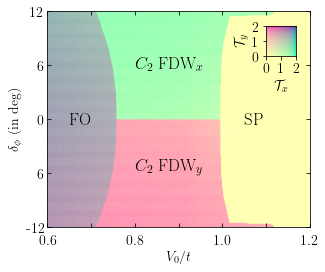

In [30]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 14

fig, ax = plt.subplots(figsize=[53 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
#ax.set_aspect("equal")

y = np.linspace(angle_values[0].real, angle_values[-1].real, 300)/200 
x = np.linspace(V_0_arr[0].real, V_0_arr2[-1].real, 600)/t 

y1 = -np.linspace(angle_values[0].real, angle_values[-1].real, 300)/200 

'''
A very simple colormap:
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the blue channel
'''
green_frac = 0.7
cmap = lambda p1,p2 : ((1-np.abs(p1/2))**(1/3), (1-np.abs(p2/2))**(1/3), green_frac)

p1 = Ty_gs_int_angle 
p2 = Tx_gs_int_angle 
for j in range(len(y)):
    for i in range(len(x)):
        circle = matplotlib.patches.Rectangle((x[i], y[j]), 0.000007, 0.000007, color=cmap(p1[j,i],p2[j,i])) #p1[j,i],p2[j,i]))
        ax.add_artist(circle)

        circle = matplotlib.patches.Rectangle((x[i], y1[j]), 0.000007, 0.000007, color=cmap(p2[j,i],p1[j,i])) #p1[j,i],p2[j,i]))
        ax.add_artist(circle)

#ax.annotate(r'b)', xy=(0.2, -0.1), xytext=(-0.5, 1.5), fontsize=25, color='black')

ax.annotate(r'FO', xy=(0.65, -0.00015), xytext=(0.65, -0.00005), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_x$', xy=(0.8, 0.0005), xytext=(0.8, 0.0005), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_y$', xy=(0.8, -0.0005), xytext=(0.8, -0.0005), fontsize=17, color='black')
ax.annotate(r'SP', xy=(1.05, -0.00051), xytext=(1.05, -0.00005), fontsize=17, color='black')

plt.xlim(0.6,1.2)
plt.ylim(-0.0010472,0.0010472)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\delta_{\phi}$ (in deg)', fontsize=font_size)

plt.xticks([0.6,0.7,0.8,0.9,1.0,1.1,1.2], [r'0.6',r'',r'0.8',r'',r'1.0',r'',r'1.2'], fontsize=font_size)
plt.yticks([-0.0010472,-0.0010472/2,0,0.0010472/2,0.0010472], [r'-12',r'6',r'0',r'6',r'12'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.subplots_adjust(left=0.1, right=0.65, top=0.85)
cax = fig.add_axes([0.54,0.7,0.1,0.1]) #([0.54,0.7,0.1,0.1]) #fig.add_axes([0.72,0.55,0.3,0.3])
cp1 = np.linspace(0, 1, 100)
cp2 = np.linspace(0, 1, 100)
Cp1, Cp2 = np.meshgrid(cp1,cp2)
C0 = green_frac*np.ones_like(Cp2)
# make RGB image, p1 to red channel, p2 to blue channel
Legend = np.dstack(((1-Cp1)**(1/3),(1-Cp2)**(1/3),C0))

# parameters range between 0 and 1
cax.imshow(Legend, origin="lower", extent=[0,2,0,2])
cax.set_xticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_yticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_xlabel(r'$\mathcal{T}_x$', fontsize=font_size)
cax.set_ylabel(r'$\mathcal{T}_y$', fontsize=font_size)

plt.savefig('results/phase_diagram_sym_breaking_angle/order_parameters_int_variation_B_2.0.pdf', bbox_inches='tight', dpi=50)

To complement this analysis, we show the energy behaviour in this part of the phase diagram.

In [33]:
x_curve_left = np.linspace(0.7,0.75,100)
y_curve_left_u = 0.006*(-x_curve_left+0.75)**(0.5)

x_curve_right = np.linspace(1.0,1.05,100)
y_curve_right_u = 0.007*(x_curve_right-1)**(0.5)

x_curve_middle = np.linspace(0.75,1.0,100)
y_curve_middle = 0*x_curve_middle

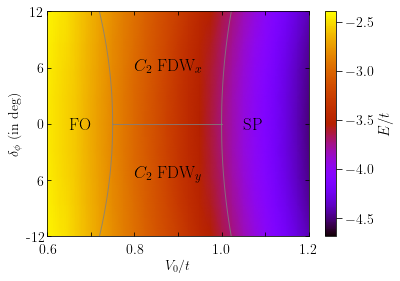

In [34]:
t = 200
X, Y = np.meshgrid(V_0_arr_tot.real, angle_values.real)

#X_intp1, Y_intp1, E_gs_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_gs.real)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 14

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

#pc = plt.pcolormesh(X,Y,E_gs.real, linewidth=0.)
ax.pcolormesh(X/t, -Y/t, E_gs_tot_angle.real/t, antialiased=False, cmap='gnuplot', shading='gouraud')
pc = ax.pcolormesh(X/t, Y/t, E_gs_tot_angle.real/t, antialiased=False, cmap='gnuplot', shading='gouraud')

cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$E/t$', size=15)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

plt.plot(x_curve_middle, y_curve_middle, linestyle='solid', linewidth=1, color='grey', alpha=0.8)
plt.plot(x_curve_left, y_curve_left_u, linestyle='solid', linewidth=1, color='grey', alpha=0.8)
plt.plot(x_curve_left, -y_curve_left_u, linestyle='solid', linewidth=1, color='grey', alpha=0.8)
plt.plot(x_curve_right, y_curve_right_u, linestyle='solid', linewidth=1, color='grey', alpha=0.8)
plt.plot(x_curve_right, -y_curve_right_u, linestyle='solid', linewidth=1, color='grey', alpha=0.8)
        
ax.annotate(r'FO', xy=(0.65, -0.00015), xytext=(0.65, -0.00005), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_x$', xy=(0.8, 0.0005), xytext=(0.8, 0.0005), fontsize=17, color='black')
ax.annotate(r'$C_2$ FDW$_y$', xy=(0.8, -0.0005), xytext=(0.8, -0.0005), fontsize=17, color='black')
ax.annotate(r'SP', xy=(1.05, -0.00051), xytext=(1.05, -0.00005), fontsize=17, color='black')

plt.xlim(0.6,1.2)
plt.ylim(-0.0010472,0.0010472)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$\delta_{\phi}$ (in deg)', fontsize=font_size)

plt.xticks([0.6,0.7,0.8,0.9,1.0,1.1,1.2], [r'0.6',r'',r'0.8',r'',r'1.0',r'',r'1.2'], fontsize=font_size)
plt.yticks([-0.0010472,-0.0010472/2,0,0.0010472/2,0.0010472], [r'-12',r'6',r'0',r'6',r'12'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True, pad=7, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True, labelsize=font_size)

Calculation schedule:

- 10 steps from 120 to 130 to resolve the couplings nicely for the couplings -0.3,-0.2,-0.1,0.0 for fdv, fo and 0.3,0.2,0.1,0.0 for fdh, fo

- then energies from 0 to 50 for fo, -0.3,-0.2,-0.1,0.0,0.1,0.2,0.3

# Coupling between the states

Here we analyze the couplings between the different phases.

TODO: read in here the calculation results at the coupling points and compute the overlap matrices! - calculations were started on the 04th December and might take some time!

In [83]:
def get_E_coupl(file_path_1, file_path_2, V_0_arr, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()

    E0_1_arr = np.zeros(len(V_0_arr), dtype=complex)
    E0_2_arr = np.zeros(len(V_0_arr), dtype=complex)
    
    E1_arr = np.zeros(len(V_0_arr), dtype=complex)
    E2_arr = np.zeros(len(V_0_arr), dtype=complex)
    
    i = 0
    for V in V_0_arr:
        check_sym_n = check_sym+'_V0_'+str(V)
 
        file_list_1 = [f for f in os.listdir(file_path_1) if check_size in f and check_sym_n in f]
        file_list_2 = [f for f in os.listdir(file_path_2) if check_size in f and check_sym_n in f]

        psi1, params1 = h5_io_object.get_psi(file_path_1+file_list_1[0])
        psi2, params2 = h5_io_object.get_psi(file_path_2+file_list_2[0])

        n_states = 2
        psi_arr = [psi1,psi2]
        q_arr = [np.array([0,0]),np.array([0,0])]
        
        coupl_object = energy.coupling_of_states(params=params1)

        h_eff, s_ove = coupl_object.calc_hamiltonian(n_states, psi_arr, q_arr)

        eigen_values, eigen_vector = scipy.linalg.eig(a=h_eff, b=s_ove) # diagonalize effective hamiltonian
        order = np.argsort(eigen_values)
        eigen_vector = eigen_vector[:,order]
        eigen_values = eigen_values[order]

        E0_1_arr[i] = h_eff[0,0]
        E0_2_arr[i] = h_eff[1,1]

        E1_arr[i] = eigen_values[0]
        E2_arr[i] = eigen_values[1]

        i += 1

    return E0_1_arr, E0_2_arr, E1_arr, E2_arr

In [35]:
diff_tx_ty_sym = np.array([0])

''' 
FO Results
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_fo_coupl_t1, E_fo_coupl_t1, Tx_fo_coupl_t1, Ty_fo_coupl_t1 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


''' 
FDh Results
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/fdh/t1/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdh_coupl_t1, E_fdh_coupl_t1, Tx_fdh_coupl_t1, Ty_fdh_coupl_t1 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/fdh/t2/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdh_coupl_t2, E_fdh_coupl_t2, Tx_fdh_coupl_t2, Ty_fdh_coupl_t2 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)



''' 
SP Results
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sp_coupl_t2, E_sp_coupl_t2, Tx_sp_coupl_t2, Ty_sp_coupl_t2 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)

Reading results from FO calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from SP calculations - please wait!


### Coupling between FO and FDW$_x$ for $\Delta_t = 0$

In [114]:
V_0_arr_coupl1_test = np.array([118,119,120,121,122,123,124])

check_sym = 'tx_100.0_ty_100.0'
check_size = '_B_1.0_Mx_32_My_32'
file_path_1 = 'results/phase_diagram/couplings_detail/fo/'
file_path_2 = 'results/phase_diagram/couplings_detail/fdh/t1/'

E0_1, E0_2, E1_coupl, E2_coupl = get_E_coupl(file_path_1, file_path_2, V_0_arr_coupl1_test, check_size, check_sym)

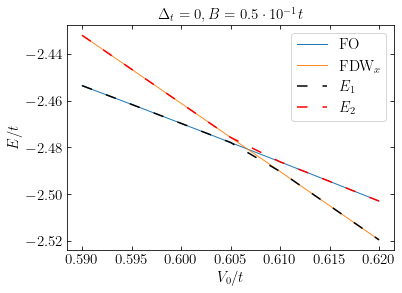

In [121]:
t = 200

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$\Delta_t = 0, B=0.5\cdot 10^{-1}t$', fontsize=font_size)

plt.plot(V_0_arr_coupl1_test/t, E0_1.real/t, label=r'FO', linewidth=1, alpha=0.9)
plt.plot(V_0_arr_coupl1_test/t, E0_2.real/t, label=r'FDW$_x$', linewidth=1, alpha=0.9)

plt.plot(V_0_arr_coupl1_test/t, E1_coupl.real/t, color='black', linestyle='dashed', dashes=(7,10), label=r'$E_1$')
plt.plot(V_0_arr_coupl1_test/t, E2_coupl.real/t, color='red', linestyle='dashed', dashes=(7,10), label=r'$E_2$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=1)
#plt.savefig('results/phase_diagram/vGH_energies_larger_B_symmetric_lattice.svg', bbox_inches='tight', dpi=50)

### Coupling between FDW$_x$ and SP for $\Delta_t = 0$

In [129]:
V_0_arr_coupl1_test = np.array([166,167,168,169,170,171,172,173])

check_sym = 'tx_100.0_ty_100.0'
check_size = '_B_1.0_Mx_32_My_32'
file_path_1 = 'results/phase_diagram/couplings_detail/fdh/t2/'
file_path_2 = 'results/phase_diagram/couplings_detail/sp/'

E0_1, E0_2, E1_coupl, E2_coupl = get_E_coupl(file_path_1, file_path_2, V_0_arr_coupl1_test, check_size, check_sym)

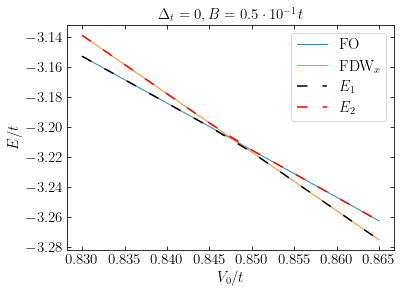

In [131]:
t = 200

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$\Delta_t = 0, B=0.5\cdot 10^{-1}t$', fontsize=font_size)

plt.plot(V_0_arr_coupl1_test/t, E0_1.real/t, label=r'FDW$_x$', linewidth=1, alpha=0.9)
plt.plot(V_0_arr_coupl1_test/t, E0_2.real/t, label=r'SP', linewidth=1, alpha=0.9)

plt.plot(V_0_arr_coupl1_test/t, E1_coupl.real/t, color='black', linestyle='dashed', dashes=(7,10), label=r'$E_1$')
plt.plot(V_0_arr_coupl1_test/t, E2_coupl.real/t, color='red', linestyle='dashed', dashes=(7,10), label=r'$E_2$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=1)
#plt.savefig('results/phase_diagram/vGH_energies_larger_B_symmetric_lattice.svg', bbox_inches='tight', dpi=50)

### Coupling between FO and FDW$_x$ for $\Delta_t = 0.1t$

In [124]:
V_0_arr_coupl1_test = np.array([107.0,108.0,108.5,109.0,110.0,111.0])

check_sym = 'tx_110.0_ty_90.0'
check_size = '_B_1.0_Mx_32_My_32'
file_path_1 = 'results/phase_diagram/couplings_detail/fo/'
file_path_2 = 'results/phase_diagram/couplings_detail/fdh/t1/'

E0_1, E0_2, E1_coupl, E2_coupl = get_E_coupl(file_path_1, file_path_2, V_0_arr_coupl1_test, check_size, check_sym)

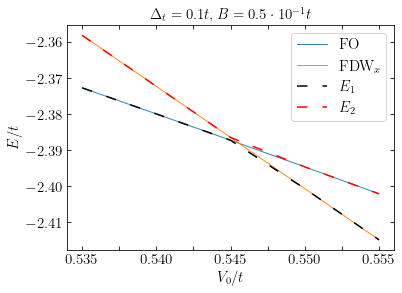

In [125]:
t = 200

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$\Delta_t = 0.1t, B=0.5\cdot 10^{-1}t$', fontsize=font_size)

plt.plot(V_0_arr_coupl1_test/t, E0_1.real/t, label=r'FO', linewidth=1, alpha=0.9)
plt.plot(V_0_arr_coupl1_test/t, E0_2.real/t, label=r'FDW$_x$', linewidth=1, alpha=0.9)

plt.plot(V_0_arr_coupl1_test/t, E1_coupl.real/t, color='black', linestyle='dashed', dashes=(7,10), label=r'$E_1$')
plt.plot(V_0_arr_coupl1_test/t, E2_coupl.real/t, color='red', linestyle='dashed', dashes=(7,10), label=r'$E_2$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

plt.xticks([0.535,0.5375,0.54,0.5425,0.545,0.5475,0.55,0.5525,0.555],[r'0.535',r'',r'0.540',r'',r'0.545',r'',r'0.550',r'',r'0.555'],fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=1)
#plt.savefig('results/phase_diagram/vGH_energies_larger_B_symmetric_lattice.svg', bbox_inches='tight', dpi=50)

In [38]:
diff_tx_ty_sym = np.array([20])

''' 
FO Results
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_fo_coupl_t1, E_fo_coupl_t1, Tx_fo_coupl_t1, Ty_fo_coupl_t1 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


''' 
FDh Results
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/fdh/t1/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdh_coupl_t1, E_fdh_coupl_t1, Tx_fdh_coupl_t1, Ty_fdh_coupl_t1 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)


check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/fdh/t2/'

print('Reading results from FDh calculations - please wait!')
#V_0_arr_fdh_coupl_t2, E_fdh_coupl_t2, Tx_fdh_coupl_t2, Ty_fdh_coupl_t2 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)



''' 
SP Results
'''
check_size = '_B_1.0_Mx_32_My_32'
file_path = 'results/phase_diagram/couplings_detail/sp/'

print('Reading results from SP calculations - please wait!')
#V_0_arr_sp_coupl_t2, E_sp_coupl_t2, Tx_sp_coupl_t2, Ty_sp_coupl_t2 = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_sym, file_path)

Reading results from FO calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from FDh calculations - please wait!
Reading results from SP calculations - please wait!
